# Import

In [1]:
import os

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
print mnist.train.images[0:5000].shape

(5000, 784)


In [3]:
#MNIST data image of shape 28*28=784
#mnist_size = 784
X = tf.placeholder(tf.float32, shape=[None, 784])
Z = tf.placeholder(tf.float32, shape=[None, 100])

# Set up parameters for generator and discriminator

In [4]:
# Generator
# Define the variables for the generator, we will use them to build layers later
# -------------------
size_g_w1 = 100
size_g_b1 = 128
# A good way to decide the std for initializing the weights
w1_std = 1.0/tf.sqrt(size_g_w1/2.0)

G_W1 = tf.Variable(tf.random_normal(shape=[size_g_w1, size_g_b1], stddev=w1_std))
G_b1 = tf.Variable(tf.zeros(shape=[size_g_b1]))

size_g_w2 = 128
size_g_b2 = 784
w2_std = 1.0/tf.sqrt(size_g_w2/2.0)

G_W2 = tf.Variable(tf.random_normal(shape=[size_g_w2, size_g_b2], stddev=w2_std))
G_b2 = tf.Variable(tf.zeros(shape=[size_g_b2]))
# theta_G and theta_D will be feeded to different optimizers later as "var_list", 
# since currently we have two networks instead of one now.
theta_G = [G_W1, G_W2, G_b1, G_b2]

# ====================
# Discriminator
# Define the variables for the discriminator
# --------------------
size_d_w1 = 784
size_d_b1 = 128
w1_std = 1.0/tf.sqrt(size_d_w1/2.0)

D_W1 = tf.Variable(tf.random_normal(shape=[size_d_w1,size_d_b1], stddev=w1_std))
D_b1 = tf.Variable(tf.zeros(shape=[size_d_b1]))

size_d_w2 = 128
size_d_b2 = 1
w2_std = 1.0/tf.sqrt(size_d_w2/2.0)

D_W2 = tf.Variable(tf.random_normal(shape=[size_d_w2,size_d_b2], stddev=w2_std))
D_b2 = tf.Variable(tf.zeros(shape=[size_d_b2]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

# Generator module

In [5]:
def generator(z):

    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_logit = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_logit)

    return G_prob, G_logit


# Discriminator module

In [6]:
def discriminator(x):

    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

# Generate samples function

In [7]:
def sample_z(m, n):
    # randomly generate samples for generator
    return np.random.uniform(-1.0, 1.0, size = [m, n])

# Plotting samples

In [8]:
def plot_sample(samples, size1, size2):
    
    fig1 = plt.figure(figsize=(size1, size2))
    gs = gridspec.GridSpec(size1, size2)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='gray')

    return fig1

# Faciliate the path defining process

In [9]:
# Though it's not possible to get the path to the notebook by __file__, os.path is still very useful in dealing with paths and files
# In this case, we can use an alternative: pathlib.Path
"""
code_dir   = os.path.dirname(__file__)
"""

code_dir = '/home/shayaan/Columbia/sem_1/Deep-Learning-for-OR-and-FE/assign4'

print code_dir
#create output_dir within the same path
output_dir = code_dir+'/outputGANs_temp/'
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

/home/shayaan/Columbia/sem_1/Deep-Learning-for-OR-and-FE/assign4


# Build GNN with defined vars and functions

In [10]:
# Put randomly generated sample Z into the generator to create "fake" images
G_sample, _ = generator(Z)
# The result of discriminator of real and fake samples
_, D_logit_real = discriminator(X)
_, D_logit_fake = discriminator(G_sample)

# generator loss 
# the goal of generator is to let discriminator make more mistakes on fake samples
# tf.ones_like returns a tensor with all elements set to 1
# 0 represent fake and 1 means real
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

# discriminator loss 
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)

# Function to create data with various noises

In [11]:
def generateNoisyData(data):
    row,col= data.shape
    #Gaussain Noise
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    gaussian_images = data + gauss
    
    #Salt and pepper noise
    s_vs_p = 0.5
    amount = 0.004
    saltandpepper_images = np.copy(data)
    # Salt mode
    num_salt = np.ceil(amount * data.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))for i in data.shape]
    saltandpepper_images[coords] = 1
    # Pepper mode
    num_pepper = np.ceil(amount* data.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))for i in data.shape]
    saltandpepper_images[coords] = 0
    
    #poisson
    vals = len(np.unique(data))
    vals = 2 ** np.ceil(np.log2(vals))
    poisson_images = np.random.poisson(data * vals) / float(vals)
    
    image = np.concatenate((data,gaussian_images,saltandpepper_images,poisson_images),axis=0)
    
    return image
    
    
    
    

In [12]:
def next_batch(data, batchSize):
    #Return a total of ‘batchSize‘ random samples
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batchSize]
    data_shuffle = np.array([data[i] for i in idx])
    return data_shuffle

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


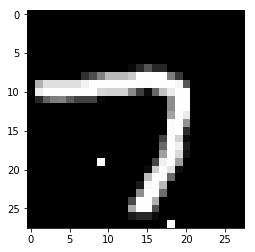

iteration: 0
D_loss: 1.38
G_loss: 2.72
()


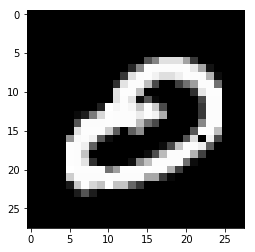

iteration: 1000
D_loss: 0.02918
G_loss: 12.1
()


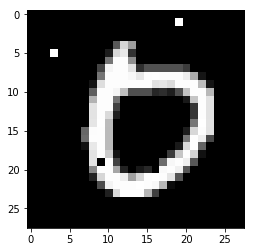

iteration: 2000
D_loss: 0.01794
G_loss: 6.783
()


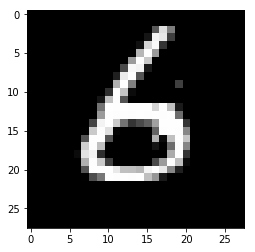

iteration: 3000
D_loss: 0.04432
G_loss: 5.681
()


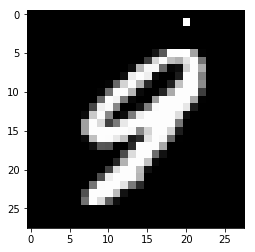

iteration: 4000
D_loss: 0.1981
G_loss: 4.541
()


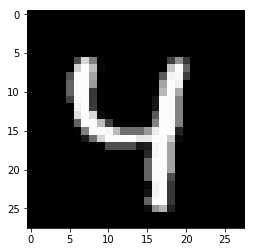

iteration: 5000
D_loss: 0.2243
G_loss: 6.445
()


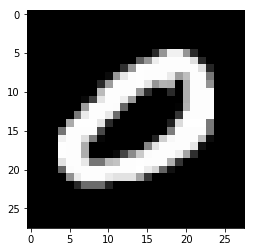

iteration: 6000
D_loss: 0.3219
G_loss: 5.608
()


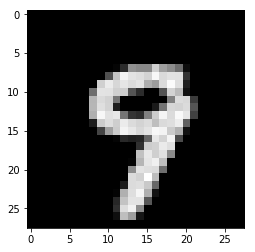

iteration: 7000
D_loss: 0.3599
G_loss: 4.919
()


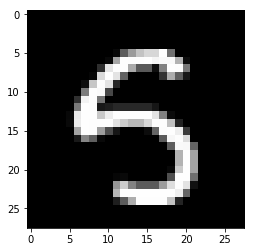

iteration: 8000
D_loss: 0.4477
G_loss: 4.303
()


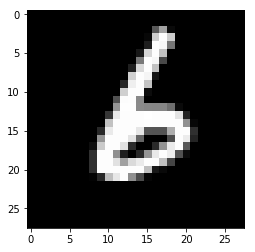

iteration: 9000
D_loss: 0.2416
G_loss: 4.368
()


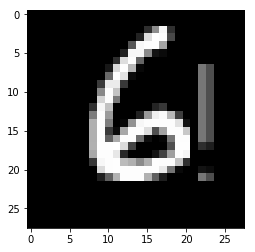

iteration: 10000
D_loss: 0.4314
G_loss: 3.054
()


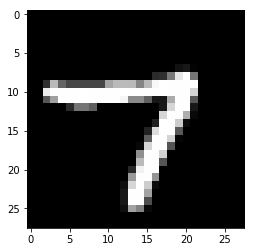

iteration: 11000
D_loss: 0.2662
G_loss: 3.415
()


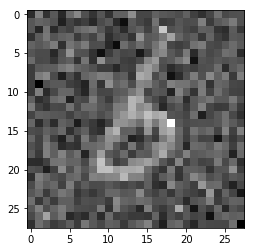

iteration: 12000
D_loss: 0.3645
G_loss: 3.096
()


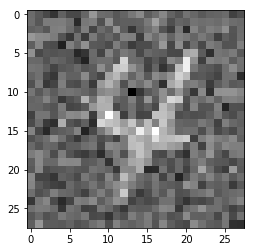

iteration: 13000
D_loss: 0.328
G_loss: 3.159
()


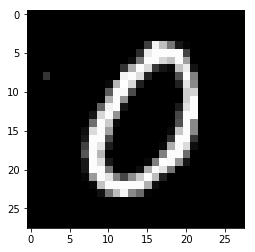

iteration: 14000
D_loss: 0.41
G_loss: 3.021
()


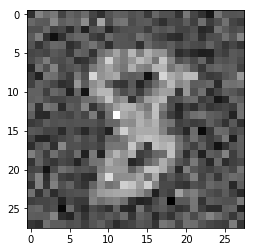

iteration: 15000
D_loss: 0.342
G_loss: 3.793
()


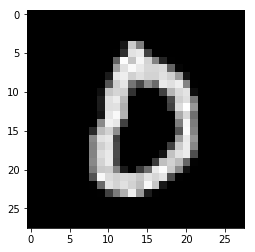

iteration: 16000
D_loss: 0.2492
G_loss: 3.1
()


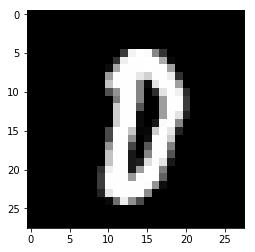

iteration: 17000
D_loss: 0.2951
G_loss: 3.063
()


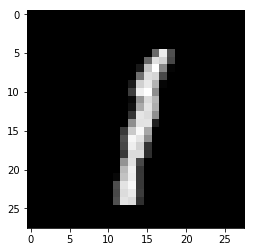

iteration: 18000
D_loss: 0.3215
G_loss: 3.61
()


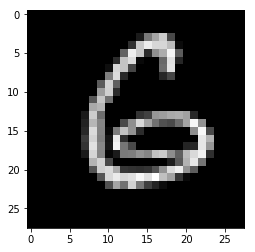

iteration: 19000
D_loss: 0.3474
G_loss: 3.838
()


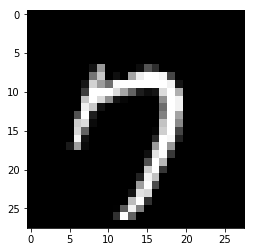

iteration: 20000
D_loss: 0.2332
G_loss: 3.389
()


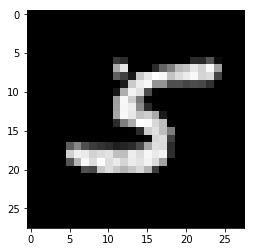

iteration: 21000
D_loss: 0.3347
G_loss: 3.571
()


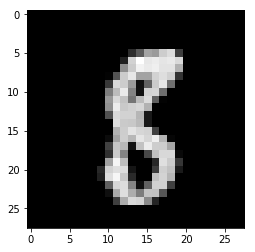

iteration: 22000
D_loss: 0.3135
G_loss: 3.518
()


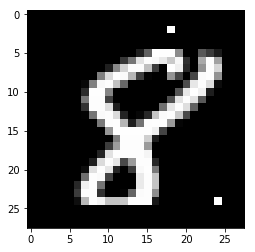

iteration: 23000
D_loss: 0.2658
G_loss: 3.424
()


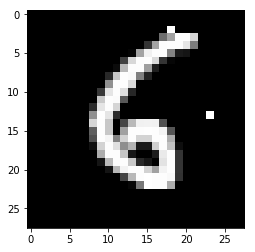

iteration: 24000
D_loss: 0.3303
G_loss: 3.544
()


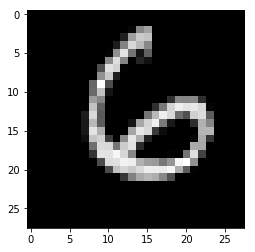

iteration: 25000
D_loss: 0.2584
G_loss: 4.144
()


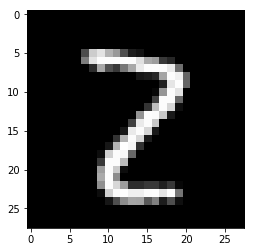

iteration: 26000
D_loss: 0.1643
G_loss: 3.645
()


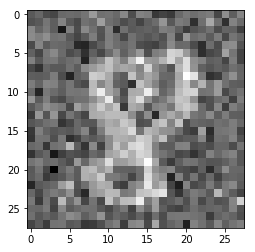

iteration: 27000
D_loss: 0.1745
G_loss: 4.619
()


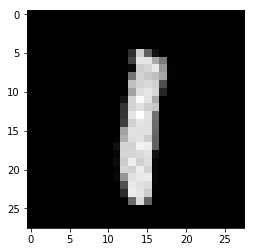

iteration: 28000
D_loss: 0.2385
G_loss: 4.541
()


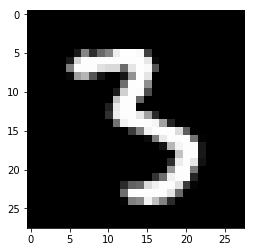

iteration: 29000
D_loss: 0.16
G_loss: 3.246
()


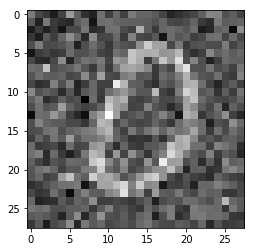

iteration: 30000
D_loss: 0.1139
G_loss: 3.428
()


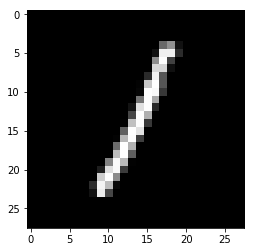

iteration: 31000
D_loss: 0.1974
G_loss: 4.205
()


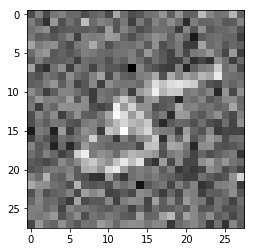

iteration: 32000
D_loss: 0.1568
G_loss: 3.576
()


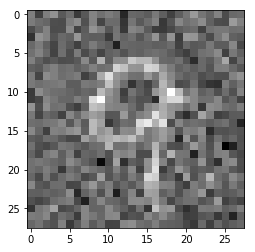

iteration: 33000
D_loss: 0.2059
G_loss: 4.317
()


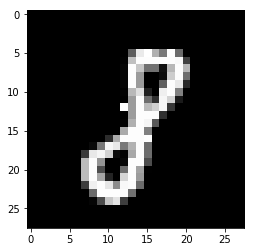

iteration: 34000
D_loss: 0.1355
G_loss: 3.7
()


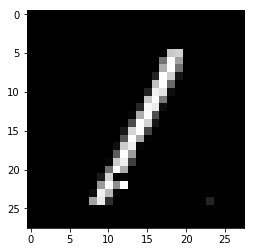

iteration: 35000
D_loss: 0.1582
G_loss: 3.591
()


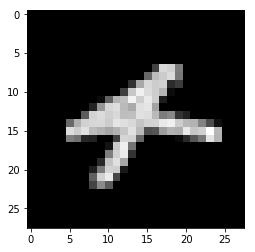

iteration: 36000
D_loss: 0.1557
G_loss: 3.583
()


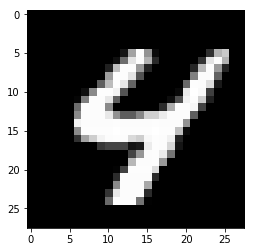

iteration: 37000
D_loss: 0.09424
G_loss: 4.623
()


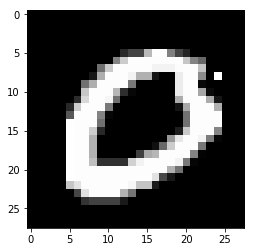

iteration: 38000
D_loss: 0.1124
G_loss: 4.402
()


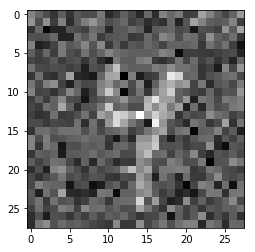

iteration: 39000
D_loss: 0.123
G_loss: 4.798
()


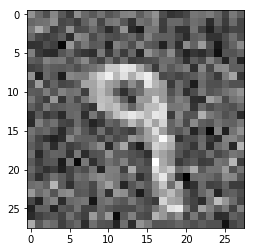

iteration: 40000
D_loss: 0.1017
G_loss: 4.245
()


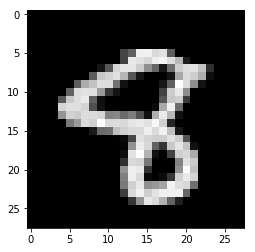

iteration: 41000
D_loss: 0.1582
G_loss: 5.063
()


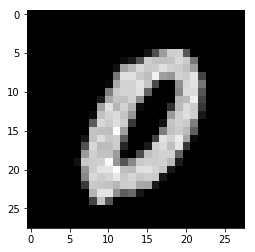

iteration: 42000
D_loss: 0.1041
G_loss: 4.338
()


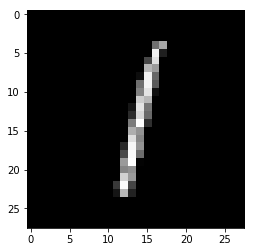

iteration: 43000
D_loss: 0.1155
G_loss: 3.998
()


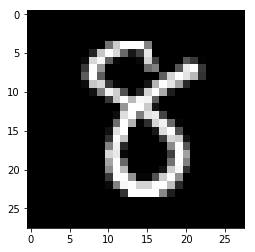

iteration: 44000
D_loss: 0.1019
G_loss: 4.311
()


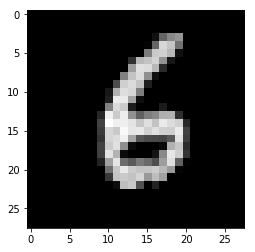

iteration: 45000
D_loss: 0.08462
G_loss: 4.652
()


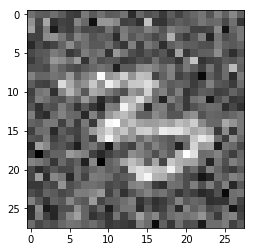

iteration: 46000
D_loss: 0.1807
G_loss: 4.152
()


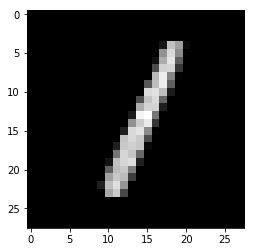

iteration: 47000
D_loss: 0.1623
G_loss: 4.738
()


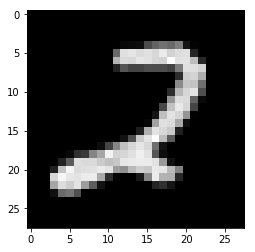

iteration: 48000
D_loss: 0.04811
G_loss: 6.446
()


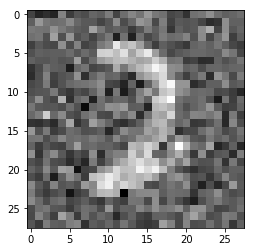

iteration: 49000
D_loss: 0.06511
G_loss: 5.648
()


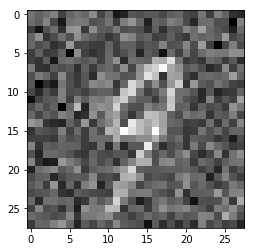

iteration: 50000
D_loss: 0.06603
G_loss: 5.03
()


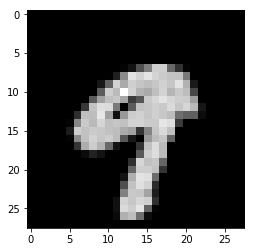

iteration: 51000
D_loss: 0.03263
G_loss: 5.005
()


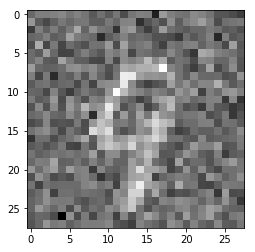

iteration: 52000
D_loss: 0.105
G_loss: 4.241
()


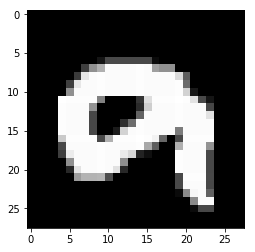

iteration: 53000
D_loss: 0.0431
G_loss: 4.674
()


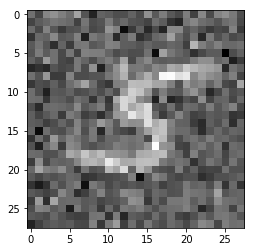

iteration: 54000
D_loss: 0.1238
G_loss: 5.511
()


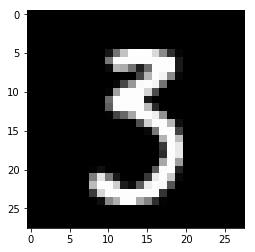

iteration: 55000
D_loss: 0.1136
G_loss: 5.065
()


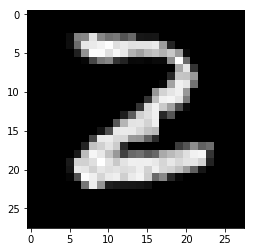

iteration: 56000
D_loss: 0.09412
G_loss: 5.534
()


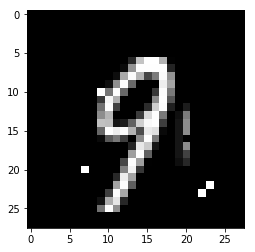

iteration: 57000
D_loss: 0.05335
G_loss: 5.277
()


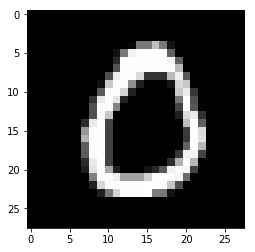

iteration: 58000
D_loss: 0.04962
G_loss: 5.617
()


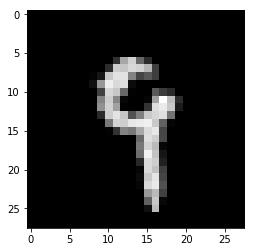

iteration: 59000
D_loss: 0.04902
G_loss: 5.684
()


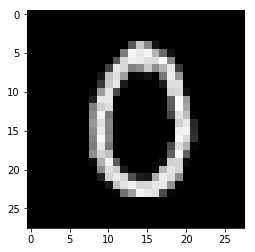

iteration: 60000
D_loss: 0.05833
G_loss: 6.745
()


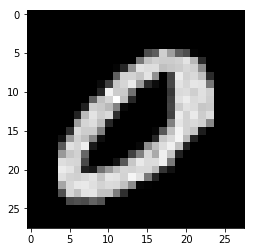

iteration: 61000
D_loss: 0.07116
G_loss: 5.431
()


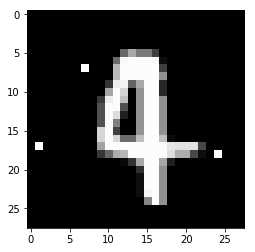

iteration: 62000
D_loss: 0.07726
G_loss: 6.168
()


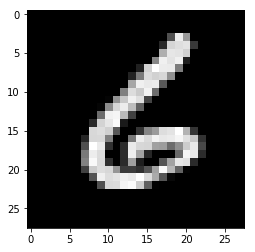

iteration: 63000
D_loss: 0.03918
G_loss: 5.131
()


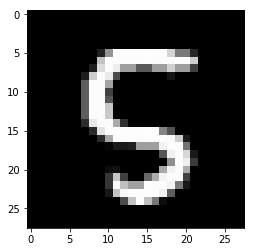

iteration: 64000
D_loss: 0.04628
G_loss: 5.74
()


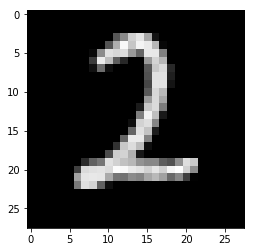

iteration: 65000
D_loss: 0.006767
G_loss: 6.575
()


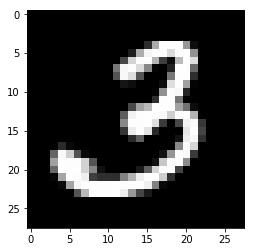

iteration: 66000
D_loss: 0.08392
G_loss: 5.889
()


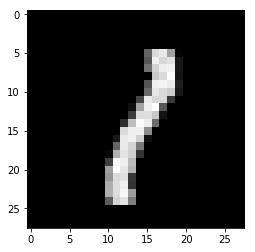

iteration: 67000
D_loss: 0.08507
G_loss: 6.034
()


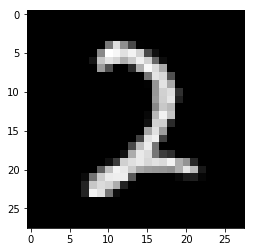

iteration: 68000
D_loss: 0.04534
G_loss: 5.142
()


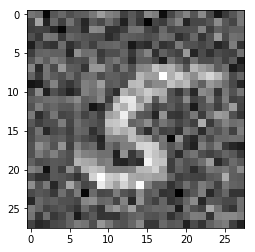

iteration: 69000
D_loss: 0.03774
G_loss: 6.277
()


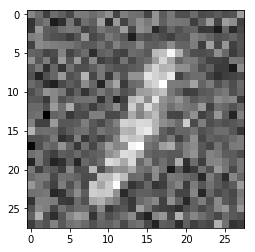

iteration: 70000
D_loss: 0.01333
G_loss: 6.053
()


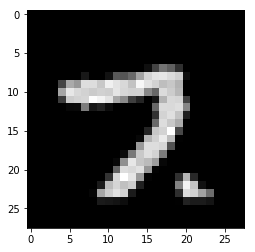

iteration: 71000
D_loss: 0.0166
G_loss: 6.104
()


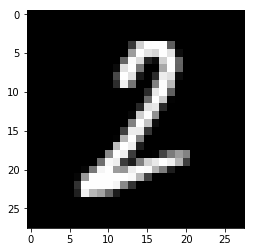

iteration: 72000
D_loss: 0.009275
G_loss: 7.227
()


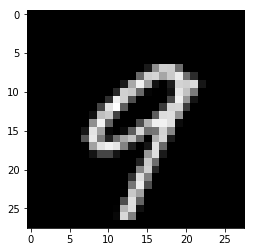

iteration: 73000
D_loss: 0.01205
G_loss: 6.946
()


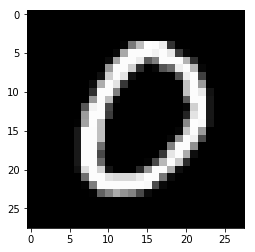

iteration: 74000
D_loss: 0.04443
G_loss: 5.68
()


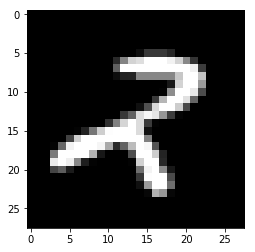

iteration: 75000
D_loss: 0.0579
G_loss: 7.156
()


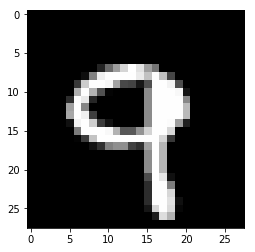

iteration: 76000
D_loss: 0.01173
G_loss: 5.393
()


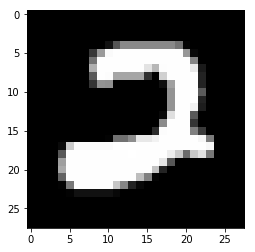

iteration: 77000
D_loss: 0.02594
G_loss: 7.51
()


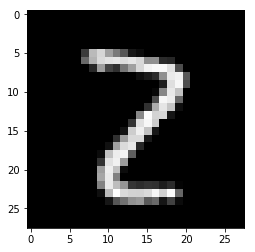

iteration: 78000
D_loss: 0.01687
G_loss: 6.572
()


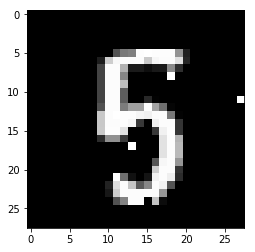

iteration: 79000
D_loss: 0.06234
G_loss: 6.371
()


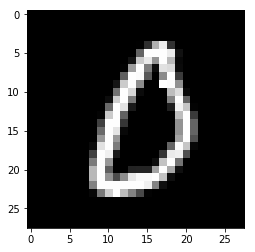

iteration: 80000
D_loss: 0.02673
G_loss: 6.708
()


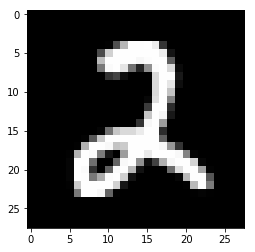

iteration: 81000
D_loss: 0.004475
G_loss: 7.14
()


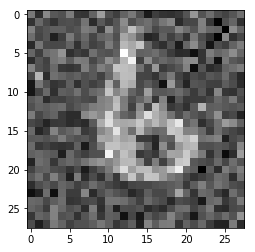

iteration: 82000
D_loss: 0.005014
G_loss: 7.485
()


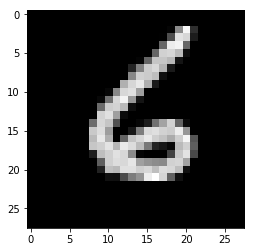

iteration: 83000
D_loss: 0.007305
G_loss: 6.243
()


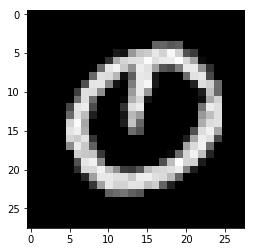

iteration: 84000
D_loss: 0.05218
G_loss: 7.683
()


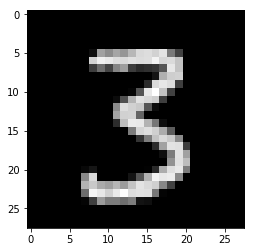

iteration: 85000
D_loss: 0.009357
G_loss: 7.665
()


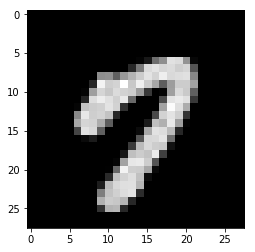

iteration: 86000
D_loss: 0.03263
G_loss: 7.081
()


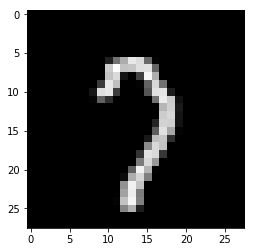

iteration: 87000
D_loss: 0.0375
G_loss: 6.65
()


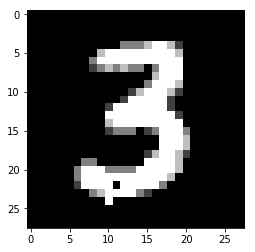

iteration: 88000
D_loss: 0.03598
G_loss: 7.089
()


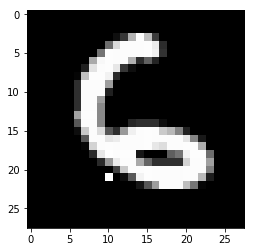

iteration: 89000
D_loss: 0.03209
G_loss: 5.914
()


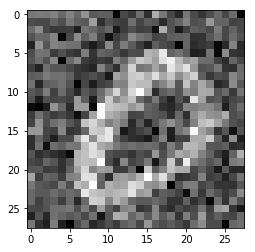

iteration: 90000
D_loss: 0.06919
G_loss: 5.613
()


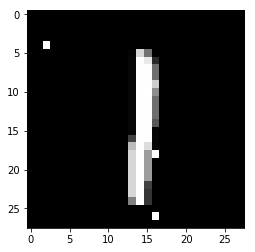

iteration: 91000
D_loss: 0.03028
G_loss: 7.211
()


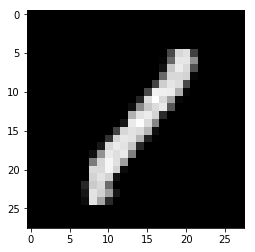

iteration: 92000
D_loss: 0.01908
G_loss: 7.698
()


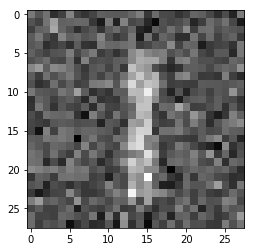

iteration: 93000
D_loss: 0.001819
G_loss: 7.487
()


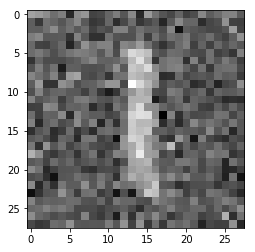

iteration: 94000
D_loss: 0.04066
G_loss: 6.183
()


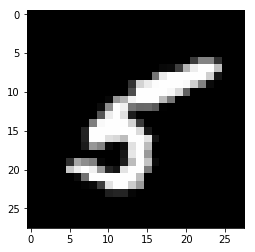

iteration: 95000
D_loss: 0.02469
G_loss: 7.843
()


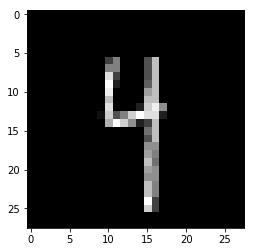

iteration: 96000
D_loss: 0.008627
G_loss: 7.294
()


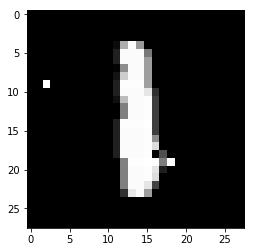

iteration: 97000
D_loss: 0.04394
G_loss: 6.83
()


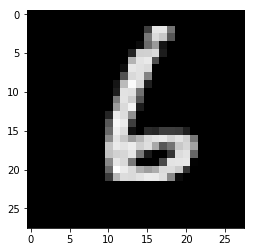

iteration: 98000
D_loss: 0.003168
G_loss: 7.944
()


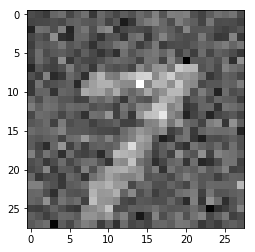

iteration: 99000
D_loss: 0.008438
G_loss: 6.688
()


In [13]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 128
# the dimension of the random samples
z_dim = 100
result_freq = 1000
# plot generators' output every figure_iter step
figure_iter = 1000
max_iter = 100000
size1 = 5
size2 = 5
i = 0
img = generateNoisyData(mnist.train.images[:5000])
print img.shape
for iter in range(max_iter):
    
    if iter % figure_iter == 0:
        
        # G_sample is a sample from the generator
        samples = sess.run(G_sample, feed_dict={Z: sample_z(size1*size2, z_dim)})

        fig1 = plot_sample(samples, size1, size2)
        plt.savefig(output_dir + 'GANs' + str(i) + '.png', bbox_inches='tight')
        i += 1
        plt.close(fig1)

    batch_xs = next_batch(img,batch_size)
    
    _, discriminator_loss = sess.run([D_solver, D_loss], feed_dict={X: batch_xs, Z: sample_z(batch_size, z_dim)})
    _, generator_loss     = sess.run([G_solver, G_loss], feed_dict={Z: sample_z(batch_size, z_dim)})

    if iter % result_freq == 0:
        first_image = batch_xs[0]
        first_image = np.array(first_image, dtype='float')
        pixels = first_image.reshape((28, 28))
        plt.imshow(pixels, cmap='gray')
        plt.show()
        print('iteration: {}'.format(iter))
        print('D_loss: {:0.4}'.format(discriminator_loss))
        print('G_loss: {:0.4}'.format(generator_loss))
        print()